## Association Rule Mining

The cleaned dataset (Modified_plants.csv) was mined using various techniques to obtaining interesting rules and patters  by implementing  the following algorithms:
  * FIM:
    * Apriori
    * FP Growth
  * CFI
    * A-Close (modified version of apriori)
  * MFI
    * FP max



### Importing Necessary Libraries


In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
from apyori import apriori
from mlxtend.frequent_patterns import apriori as a_close
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import fpmax
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
 

### Apriori Algorithm
* To implement thhe alogirthm,  the cleaned dataset was converted into a  'list of lists' format. 
* The  'Symbol' column is split into it's consitutent letters to get meanignful insights.
* The resultant rules obtained are written to a file in the csv format. The top five rows are displayed below. 

### Evaluation Measures:
* The measures of Confidence and Lift were used to evaluate the rules mined. 
* Confidence
    * Conf(X=>Y) = Supp(X\cupY) \div Supp(X) –
    * It measures how often each item in Y appears in transactions that contains items in X also.
* Lift
    * LiftX=>Y) = Conf(X=>Y) \div Supp(Y)
    * Lift value near 1 indicates X and Y almost often appear together as expected.
    * Greater than 1 means they appear together more than expected.
    * Less than 1 means they appear less than expected.
    * Greater lift values indicate stronger association.

In [13]:

data = pd.read_csv('Datasets/Modified_Plants.csv')
print(data.head(5))
df = []

for _,row in data.iterrows():
    value = []
    for item in row['Symbol']:
        value.append(item)
    for item in row[1:]:
        value.append(item)
    df.append(value) 

rules = apriori(df, min_support=0.01, min_confidence=0.4, min_lift=3, min_length=2)
rules = list(rules)
apriori_results = pd.DataFrame(columns=['Rule','Support','Confidence','Lift'])
# print(apriori_results.head(5))
for rule in rules:
    supp = rule[1]
    conf = rule[2][0][-2]
    lift = rule[2][0][-1]

    Rule = ''
    Rule += next(iter(rule[2][0][0]))
    for item in rule[2][0][1:-3]:
        Rule += ',' + next(iter(item))
    Rule += ' -- > '
    Rule += next(iter(rule[2][0][-3]))
    
    row = [Rule,supp,conf,lift]

    apriori_results = apriori_results.append(pd.Series(row,index=apriori_results.columns),ignore_index=True)
print(apriori_results.head(5))
apriori_results.to_csv('Rules/Apriori_rules.csv')


Symbol Syn_Symbol       Family    Sci_Name_1  Sci_Name_2
0  ANDRO5      JUEC2  Acanthaceae  Andrographis       Wall.
1    ANEC      JUEC2  Acanthaceae  Andrographis   echioides
2    ANEC      JUEC2  Acanthaceae      Justicia   echioides
3   DIBR2      JUEC2  Acanthaceae    Dicliptera   brachiata
4   DIBR2      DIBR6  Acanthaceae     Diapedium  brachiatum
                       Rule   Support  Confidence      Lift
0     Aster -- > Asteraceae  0.013829    1.000000  8.112179
1              Aster -- > S  0.011458    0.828571  3.502975
2              Aster -- > Y  0.010404    0.752381  8.285466
3  Solidago -- > Asteraceae  0.010734    1.000000  8.112179
4              Carex -- > C  0.027328    1.000000  3.295573


### FP Growth Algorithm
* The given dataset contains a large number of uniwue values in the 'Family' column and as such is not suitable for encoding. 
* Therefore the dataset is grouped by 'Family' and only those families with number of rows >=500 are chosen for encoding.
* After grouping by family, the data is grouped by symbol, and only those with more than 25 rows are taken. 
* The resultant datset contains 345 rows and 6 columns. - It is written into a csv file - 'Pruned_Data.csv'
* All further analysis is done on this dataset.  
* The data is enoded using the transaction encoder which is a part of the mlxtend library. 
* The resultant rules obtained are written to a file in the csv format. The top five rows are displayed below.

Evaluation Measures:
The following measures were used to evaluate the rules mined:
* Confidence
    * Conf(X=>Y) = Supp(X\cupY) \div Supp(X) 
    * It measures how often each item in Y appears in transactions that contains items in X also.

* Lift
    * LiftX=>Y) = Conf(X=>Y) \div Supp(Y)
    * Lift value near 1 indicates X and Y almost often appear together as expected.
    * Greater than 1 means they appear together more than expected.
    * Less than 1 means they appear less than expected.
    * Greater lift values indicate stronger association.

* Conviction 
    * It determines which part of the association rule has the upper hand; whether the L.H.S drives the R.H.S or vice versa.
    * Conviction(A →B) = (1- support(B)) / (1- Confidence(A →B)).
    * A high conviction value means that the consequent is highly depending on the antecedent. 
    * In the case of a perfect confidence score, the denominator becomes 0 (due to 1 - 1) for which the conviction score is defined as inf . 
    * Similar to lift, if items are independent, the conviction is 1.

* A rule can be divided into two parts - antecedent and consequent. 
    * The antecedent refers to the condition, clause or item, and the consequent refers to what it implies or its consequence. 
    * The suppoer for the antecedent as well as the consequent is also calculated.

* Leverage:
    * levarage(A→C)=support(A→C)−support(A)×support(C),range: [−1,1]
    * Leverage computes the difference between the observed frequency of A and C appearing together and the frequency that would be expected if A and C were independent. 
    * A leverage value of 0 indicates independence.

* Conviction:
    * conviction(A→C)=1−support(C)1−confidence(A→C),range: [0,∞]
    * 

In [5]:



def get_rule(x,y):
    rule = '{'
    rule += list(x)[0]
    for item in list(x)[1:]:
        rule += ',' + item
    rule += '} --- > {' + list(y)[0]
    for item in list(y)[1:]:
        rule += ',' + item
    rule += '}'
    return rule


# data = pd.read_csv('Modified_Plants.csv')

data = data[data.groupby('Family')['Family'].transform('size') > 100]
data = data[data.groupby('Symbol')['Symbol'].transform('size') > 25]
data.reset_index(drop=True,inplace=True)

# print(data.shape)
# print(data.head(5))
# data.to_csv('Pruned_Data.csv',index=False)
#print(data.Family.value_counts())

te = TransactionEncoder()
enc_basket = te.fit(data).transform(data)

# print(enc_basket)

basket=pd.DataFrame(enc_basket, columns=te.columns_)
basket.to_csv('Encoded_data.csv', index=False)

fp_items=fpgrowth(basket, min_support=0.005, use_colnames=True)

fp_rules = association_rules(fp_items, metric ="lift", min_threshold = 1) 
fp_rules = fp_rules.sort_values(['confidence', 'lift'], ascending =[False, False]) 
fp_rules.drop(["leverage"], axis = 1, inplace = True)

fp_rules.reset_index(drop=True,inplace=True)
pd.set_option('display.max_columns',None)

fp_rules['Rule'] = fp_rules.apply(lambda row : get_rule(row['antecedents'],row['consequents']),axis=1)
fp_rules = fp_rules[['Rule','antecedent support','consequent support','support','confidence','lift','conviction']]
fp_rules.columns = ['Rule','Antecedent Support','Consequent Support','Support','Confidence','Lift','Conviction']

print(fp_rules.head(5))
fp_rules.to_csv('Rules/FP_Rules.csv',index=False)


Rule  Antecedent Support  Consequent Support   Support  \
0    {l,S} --- > {o}            0.005797            0.005797  0.005797   
1    {o} --- > {l,S}            0.005797            0.005797  0.005797   
2    {y,S} --- > {o}            0.005797            0.005797  0.005797   
3    {o} --- > {y,S}            0.005797            0.005797  0.005797   
4  {l,y,S} --- > {o}            0.005797            0.005797  0.005797   

   Confidence   Lift  Conviction  
0         1.0  172.5         inf  
1         1.0  172.5         inf  
2         1.0  172.5         inf  
3         1.0  172.5         inf  
4         1.0  172.5         inf  


#### Maximal Frequent Itemset
* An itemset is maximal frequent if none of its supersets are frequent.

#### Closed Frequent Itemset
* An itemset is closed if none of its immediate supersets have same support count same as Itemset.


### A-Close Algorithm (CFI) and FP Max (MFI)
 * The encoded dataset obtained in the previous stage was used to implement the the a-close and the FP Max algorithms.
 * The a-close is a modified version of apriori, to mine Closed frequent itemsets. 
 * The FP Max algorithm is a  modified version of FP growth algorithm to mine Maximal Frequent itemsets.
 * Similar to apriori and FP growth the results obtained were evaluated using various measures such as confidence, lift, conviction and leverage. 

In [6]:
# A-Close
basket = pd.read_csv('Encoded_data.csv')
a_close_itemsets= a_close(basket, min_support=0.01, use_colnames=True)
a_rules = association_rules(a_close_itemsets, metric ="lift", min_threshold = 1) 
print(a_rules.head(5))

antecedents consequents  antecedent support  consequent support   support  \
0         (m)         (S)            0.014493            0.011594  0.011594   
1         (S)         (m)            0.011594            0.014493  0.011594   

   confidence  lift  leverage  conviction  
0         0.8  69.0  0.011426    4.942029  
1         1.0  69.0  0.011426         inf  


In [7]:
# fpmax

fp_max_itemsets = fpmax(basket, min_support=0.0005, use_colnames=True,max_len = 10)
print(fp_max_itemsets)


support                     itemsets
0  0.002899  (i, 1, m, e, c, N, S, _, a)
1  0.002899  (i, m, e, c, N, 2, S, _, a)
2  0.002899           (i, m, y, l, F, a)
3  0.002899     (m, o, y, n, S, _, l, b)


## Predictive Analytics
* This dataset is not suitable for predictive analysis from a domain or subject point of view.
* Thus, any predicitve analytics techniques applied will not yield meaninfgul results from the domain/subject point of view.
* Predictive techniques have been applied on this dataset purely to demonstrate the apllication and usage of such techniques.  

The pruned dataset was encoded using an ordinal encoder from the scikit library. 
The 'Family' columns was used as  the column to be predicted,  based on the values in the other columns. 
The following Classification (Prediction of "Family") techniques were then implemented on the encoded data:
* K-Nearest Neighbours
* Support Vector Machines
* Naive-Baye's

* The data was split into two sets - train and test data for Classification. 

In [9]:
# Encoding the data
for item in data.columns:
    print(item,data[item].nunique())

enc = OrdinalEncoder()
for item in data.columns:
    data[item] = enc.fit_transform(data[item].values.reshape(-1, 1))

# Splititng into test and train

feature_names = ['Symbol', 'Syn_Symbol', 'Sci_Name_1', 'Sci_Name_2']
X = data[feature_names]
y = data['Family'] #Aim is to predict.classify the family

#scaling the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



Symbol 10
Syn_Symbol 344
Family 4
Sci_Name_1 18
Sci_Name_2 184


### Classification
* Confusion Matrix was constructed in order to evaluate the performance of each technique. 
* KNN was foind to be the most accurate for the given input. 
* A graph of 'k' vs accuracy was  plotted in order to determine the best choice of K for the given data. 

In [10]:
#KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'.format(knn.score(X_test, y_test)))


pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of K-NN classifier on training set: 0.98
Accuracy of K-NN classifier on test set: 0.94
[[ 8  0  0  0]
 [ 1  1  1  2]
 [ 0  0 32  1]
 [ 0  0  0 41]]
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94         8
         1.0       1.00      0.20      0.33         5
         2.0       0.97      0.97      0.97        33
         3.0       0.93      1.00      0.96        41

    accuracy                           0.94        87
   macro avg       0.95      0.79      0.80        87
weighted avg       0.95      0.94      0.93        87



([<matplotlib.axis.XTick at 0x7fba233a15d0>,
 <a list of 5 Text xticklabel objects>)

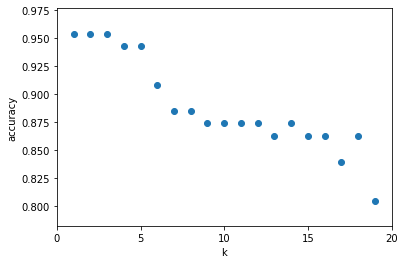

In [49]:

k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])


In [11]:
#Support Vector Machine

svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.98
Accuracy of SVM classifier on test set: 0.93
[[ 8  0  0  0]
 [ 0  1  2  2]
 [ 0  0 31  2]
 [ 0  0  0 41]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      0.20      0.33         5
         2.0       0.94      0.94      0.94        33
         3.0       0.91      1.00      0.95        41

    accuracy                           0.93        87
   macro avg       0.96      0.78      0.81        87
weighted avg       0.94      0.93      0.92        87



In [12]:
#Naive Baye's

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of GNB classifier on training set: 0.95
Accuracy of GNB classifier on test set: 0.93
[[ 8  0  0  0]
 [ 0  5  0  0]
 [ 0  0 27  6]
 [ 0  0  0 41]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         8
         1.0       1.00      1.00      1.00         5
         2.0       1.00      0.82      0.90        33
         3.0       0.87      1.00      0.93        41

    accuracy                           0.93        87
   macro avg       0.97      0.95      0.96        87
weighted avg       0.94      0.93      0.93        87

